In [1]:
import matplotlib.pyplot as plt
import numpy as np

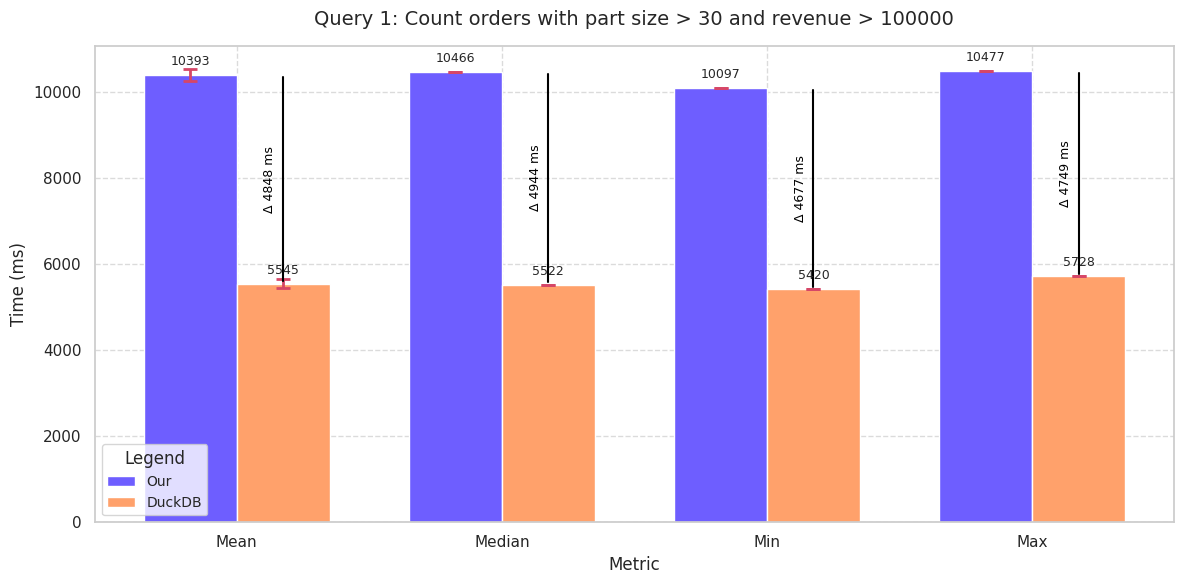

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_query_comparison(query):
    sns.set(style="whitegrid")
    labels = ['Mean', 'Median', 'Min', 'Max']  # Removed 'Std' from labels
    x = np.arange(len(labels))
    width = 0.35

    # Extract values (now without std in the main bars)
    our_vals = query['our'][:4]  # Only first 4 values (mean, median, min, max)
    duckdb_vals = query['duckdb'][:4]  # Only first 4 values
    
    # Get std values separately
    our_std = query['our'][4]
    duckdb_std = query['duckdb'][4]

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ["#6E5EFF", "#FFA16B"]

    # Draw bars
    bars_our = ax.bar(x - width/2, our_vals, width, label='Our', color=colors[0], 
                     yerr=[our_std if i == 0 else 0 for i in range(len(labels))],  # Only add std to mean (first bar)
                     error_kw=dict(ecolor='#D64667', lw=2, capsize=5, capthick=2))
    
    bars_duck = ax.bar(x + width/2, duckdb_vals, width, label='DuckDB', color=colors[1],
                      yerr=[duckdb_std if i == 0 else 0 for i in range(len(labels))],  # Only add std to mean (first bar)
                      error_kw=dict(ecolor='#D64667', lw=2, capsize=5, capthick=2))

    # Annotate bars
    for bars in [bars_our, bars_duck]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    # Draw difference lines and labels
    for i in range(len(labels)):
        h_our = our_vals[i]
        h_duck = duckdb_vals[i]
        is_our_faster = h_our < h_duck
        faster_x = x[i] - width/2 if is_our_faster else x[i] + width/2
        slower_height = h_duck if is_our_faster else h_our
        faster_height = h_our if is_our_faster else h_duck
        diff = abs(h_our - h_duck)

        # Draw difference line
        ax.plot([faster_x, faster_x], [faster_height + 50, slower_height - 50], 
                color='black', linewidth=1.5)
        
        # Place difference text vertically
        ax.annotate(f'Δ {diff:.0f} ms',
                    xy=(faster_x - 0.05, (faster_height + slower_height + 0.05)/2),
                    xytext=(0, 0), textcoords="offset points",
                    ha='center', va='center', fontsize=9, color='black',
                    rotation=90)  # Vertical text

    # Labels and styling
    ax.set_ylabel("Time (ms)", fontsize=12)
    ax.set_xlabel("Metric", fontsize=12)
    ax.set_title(query['title'], fontsize=14, pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.legend(fontsize=10, title='Legend')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('bar_diff_comparison.png', dpi=300, bbox_inches='tight')

# Example usage
query = {
    'title': 'Query 1: Count orders with part size > 30 and revenue > 100000',
    'our': [10392.6, 10466, 10097, 10477, 148.058],
    'duckdb': [5544.8, 5522, 5420, 5728, 103.588]
}

plot_query_comparison(query)

# Query 1

### Count orders with specific part size from customers
```SQL
SELECT COUNT(l.orderkey) AS order_count
                     FROM lineorder l
                     INNER JOIN customer c ON l.customer_custkey = c.custkey
                     INNER JOIN part p ON l.part_partkey = p.partkey
                     WHERE p.size > 30
                     AND l.revenue > 100000;
```

In [35]:
query1 = {
        'title': 'Query 1: Orders with part size > 30 and revenue > 100,000',
        'our': [10392.6, 10466, 10097, 10477, 148.058],
        'duckdb': [5544.8, 5522, 5420, 5728, 103.588]
    }

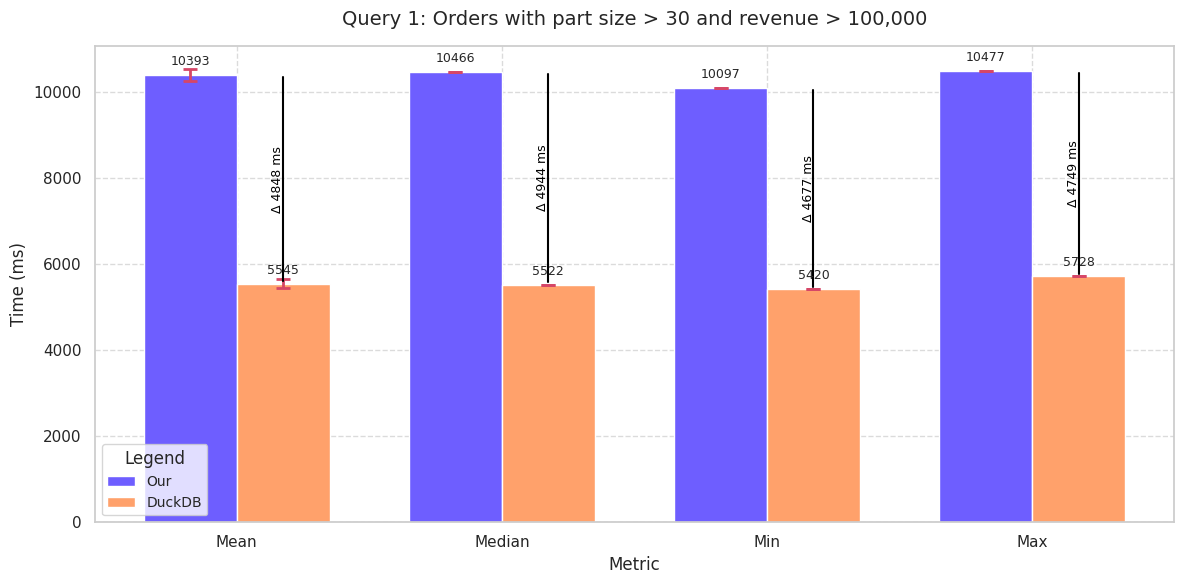

In [36]:
plot_query_comparison(query1)

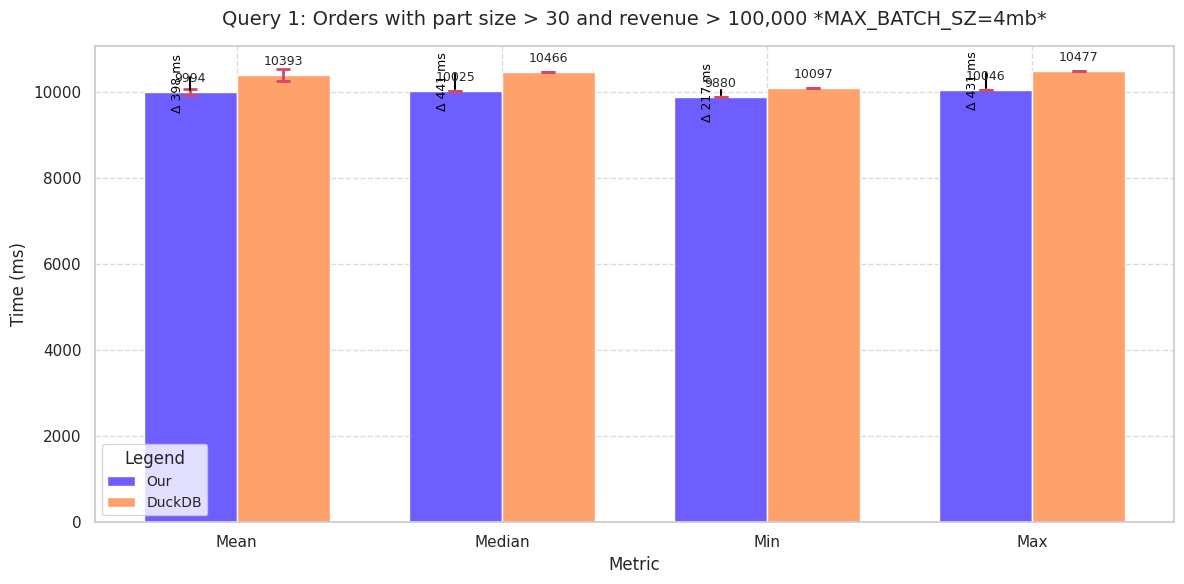

In [ ]:
query1_b = {
        'title': 'Query 1: Orders with part size > 30 and revenue > 100,000',
        'our max batch size 4mb': [9994.4, 10025, 9880, 10046, 60.6716],
        'our max batch size 6mb': [10392.6, 10466, 10097, 10477, 148.058],
        'duckdb': [5544.8, 5522, 5420, 5728, 103.588]
    }
plot_query_comparison(query1_b)

# Query 2
```SQL
SELECT l.orderkey, c.name, p.name AS part_name, s.name AS supplier_name
                FROM lineorder l
                INNER JOIN customer c ON l.customer_custkey = c.custkey
                INNER JOIN part p ON l.part_partkey = p.partkey
                INNER JOIN supplier s ON l.supplier_suppkey = s.suppkey
                WHERE c.region = 'AMERICA'
                    AND p.category = 'MFGR#12'
                    AND s.nation = 'UNITED STATES'
                    AND l.revenue > 100000;
```

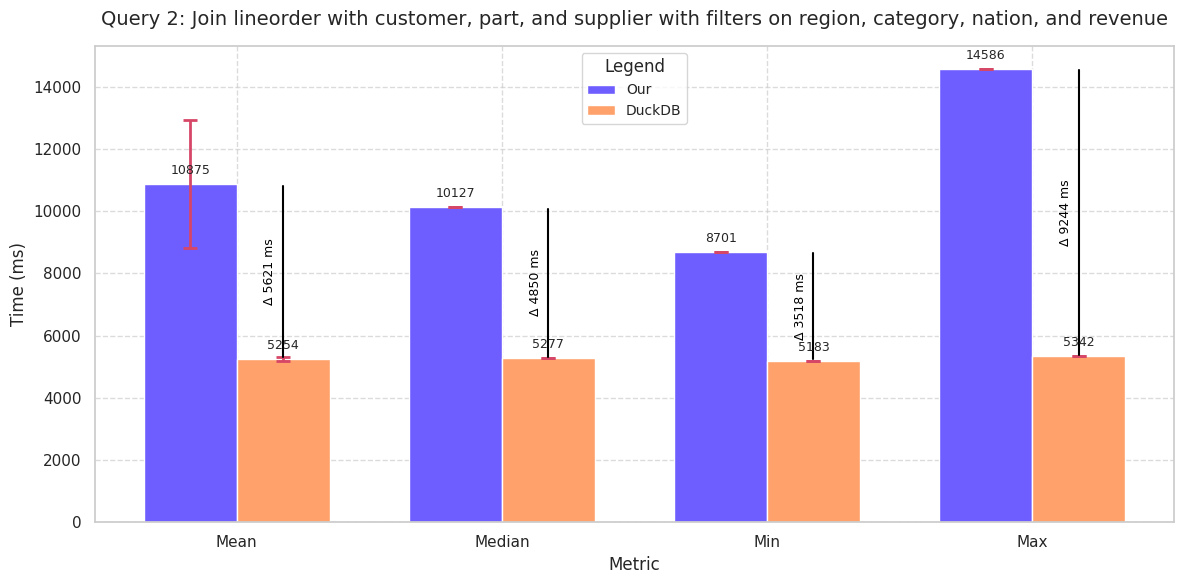

In [48]:
query = {
    'title': "Query 2: Join lineorder with customer, part, and supplier with filters on region, category, nation, and revenue",
    'our': [10875.4, 10127, 8701, 14586, 2068.87],
    'duckdb': [5254, 5277, 5183, 5342, 61.8288]
}
plot_query_comparison(query)


# Query 3
```SQL
SELECT l.orderkey, l.revenue, c.name
            FROM lineorder l
            INNER JOIN customer c ON l.customer_custkey = c.custkey
            WHERE c.region = 'AMERICA' AND l.revenue > 100000
            ORDER BY l.revenue DESC;
```

In [37]:
query2 = {
        'title': "Query 2: Revenue > 100,000 for customers in 'AMERICA'",
        'our': [4447.6, 4436, 4032, 4845, 269.53],
        'duckdb': [5935.2, 5557, 5405, 6917, 585.9]
    }


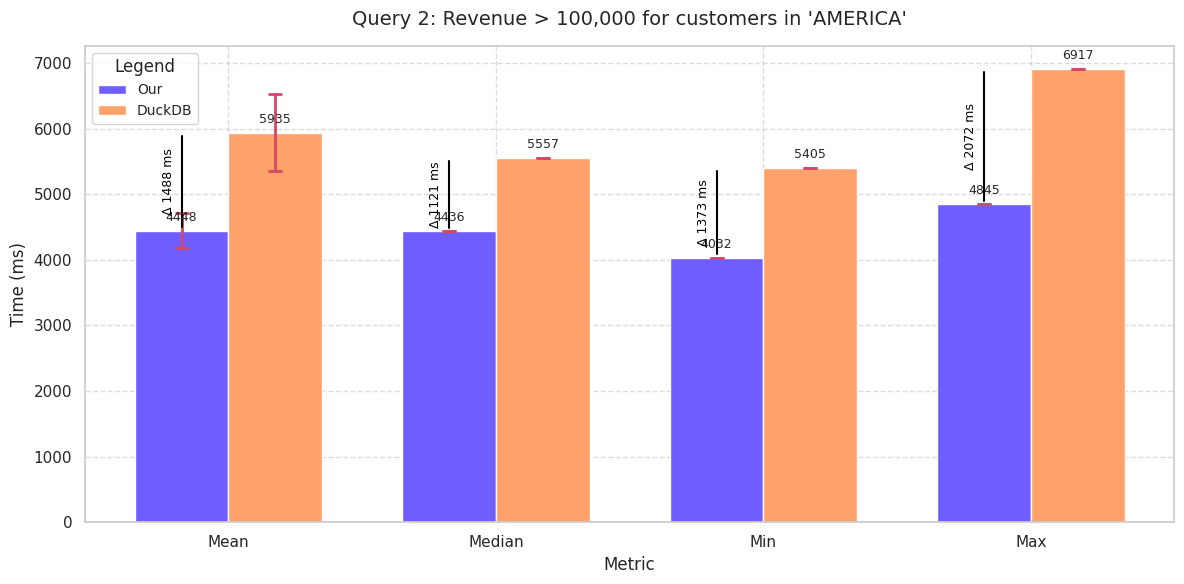

In [46]:
plot_query_comparison(query2)

# Query 4

```SQL
SELECT SUM(l.tax) AS total_tax
    FROM lineorder l
    INNER JOIN customer c ON l.customer_custkey = c.custkey
    WHERE c.mktsegment = 'AUTOMOBILE'
        AND l.tax > 0.05;
```

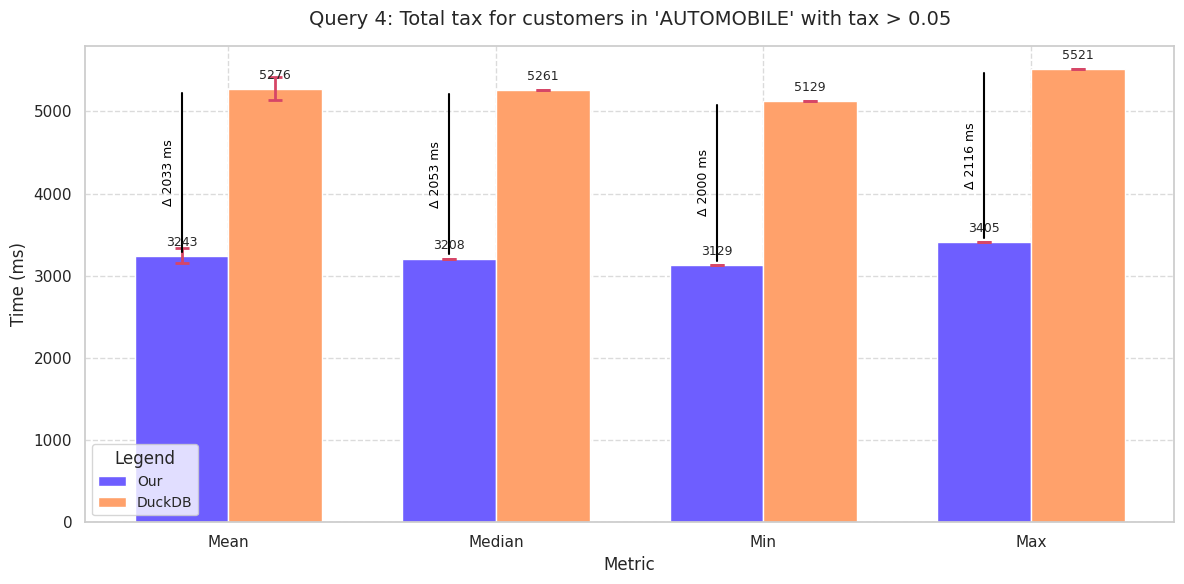

In [49]:
query4 = {
    'title': "Query 4: Total tax for customers in 'AUTOMOBILE' with tax > 0.05",
    'our': [3242.6, 3208, 3129, 3405, 93.318],
    'duckdb': [5275.8, 5261, 5129, 5521, 137.379]
}
plot_query_comparison(query4)

# Query 5
```SQL
SELECT orderkey, 
       revenue * (1 - discount) AS adjusted_revenue, 
       extendedprice + supplycost AS total_cost, 
       quantity % 10 AS quantity_remainder,
       revenue / quantity AS price_per_unit
    FROM lineorder
    WHERE orderpriority = '1-URGENT'
    AND revenue * (1 - discount) > 100000
    ORDER BY adjusted_revenue DESC;
```

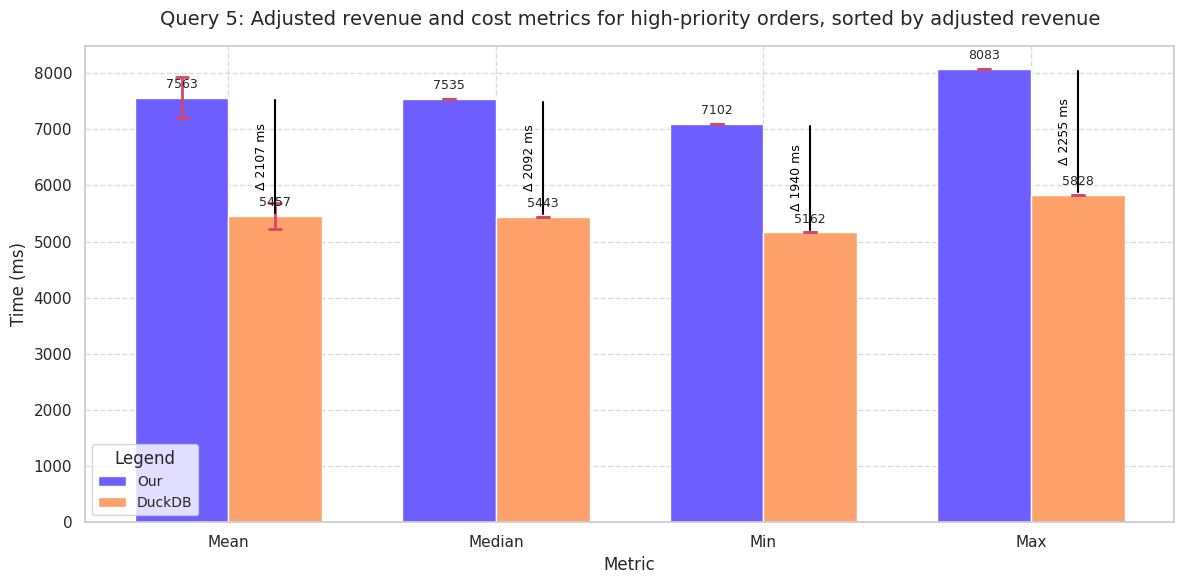

In [51]:
query5 = {
    'title': "Query 5: Adjusted revenue and cost metrics for high-priority orders, sorted by adjusted revenue",
    'our': [7563.4, 7535, 7102, 8083, 364.946],
    'duckdb': [5456.8, 5443, 5162, 5828, 237.89]
}
plot_query_comparison(query5)